# Model Gallery

This notebook demonstrates all **15 supported models** in StatPhys-ML with:
- **Clear Network Architecture Diagrams**
- **Mathematical Formulas**
- **Input-Output Relationships**

All models follow the scaling convention: $z = \frac{1}{\sqrt{d}} w^\top x = O(1)$

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrow, Rectangle, Ellipse
from matplotlib.lines import Line2D
from scipy.special import erf as scipy_erf

import statphys
statphys.fix_seed(42)
statphys.apply_paper_style()

print("StatPhys-ML Model Gallery")
print("=" * 40)
statphys.info()

StatPhys-ML Model Gallery
StatPhys-ML v0.1.0
Author: Yuma Ichikawa

Available modules:
  - dataset: Data generation (Gaussian, Sparse, Structured)
  - model: Learning models (Linear, Committee, MLP, Transformer)
  - loss: Loss functions (MSE, Ridge, LASSO, Hinge, Logistic)
  - theory: Theoretical calculations (Replica, Online ODEs)
  - simulation: Numerical experiments
  - vis: Visualization tools


## Visualization Helper Functions

In [2]:
def draw_network(ax, architecture, title="", formula="", colors=None):
    """
    Draw a clean, intuitive neural network diagram.
    
    Args:
        ax: matplotlib axis
        architecture: dict with 'layers' (list of dicts with 'n', 'label', 'type')
        title: model name
        formula: LaTeX formula
        colors: optional color scheme
    """
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-1, 6)
    ax.axis('off')
    
    layers = architecture['layers']
    n_layers = len(layers)
    
    # Default colors
    default_colors = {
        'input': '#3498db',      # Blue
        'hidden': '#e74c3c',     # Red
        'output': '#2ecc71',     # Green
        'fixed': '#95a5a6',      # Gray
        'attention': '#9b59b6',  # Purple
    }
    if colors:
        default_colors.update(colors)
    
    # Layer positions
    layer_x = np.linspace(1, 9, n_layers)
    
    node_positions = []
    
    for i, (layer, x) in enumerate(zip(layers, layer_x)):
        n_nodes = layer['n']
        label = layer.get('label', '')
        layer_type = layer.get('type', 'hidden')
        activation = layer.get('activation', '')
        fixed = layer.get('fixed', False)
        
        color = default_colors['fixed'] if fixed else default_colors.get(layer_type, '#e74c3c')
        
        # Calculate node positions
        max_show = min(n_nodes, 6)
        if n_nodes <= 6:
            y_positions = np.linspace(4.5 - 0.6*(max_show-1), 4.5, max_show)[::-1]
        else:
            y_positions = np.linspace(1.5, 4.5, 5)[::-1]
        
        positions = []
        
        # Draw nodes
        for j, y in enumerate(y_positions):
            if n_nodes > 6 and j == 2:  # Middle position for "..."
                ax.text(x, y, '⋮', fontsize=16, ha='center', va='center', color='gray')
                continue
            
            circle = Circle((x, y), 0.25, facecolor=color, edgecolor='white', 
                           linewidth=2, zorder=10, alpha=0.9)
            ax.add_patch(circle)
            positions.append((x, y))
        
        node_positions.append(positions)
        
        # Layer label (below)
        if label:
            ax.text(x, 0.3, label, fontsize=10, ha='center', va='top', fontweight='bold')
        
        # Node count
        ax.text(x, -0.2, f'({n_nodes})', fontsize=9, ha='center', va='top', color='gray')
        
        # Fixed label
        if fixed:
            ax.text(x, 5.2, 'FIXED', fontsize=7, ha='center', va='bottom', 
                   color='red', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='lightyellow', edgecolor='red', alpha=0.8))
    
    # Draw connections
    for i in range(n_layers - 1):
        layer_info = layers[i+1]
        activation = layer_info.get('activation', '')
        
        for pos1 in node_positions[i]:
            for pos2 in node_positions[i+1]:
                ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 
                       color='gray', alpha=0.3, linewidth=0.8, zorder=1)
        
        # Activation label on arrow
        if activation:
            mid_x = (layer_x[i] + layer_x[i+1]) / 2
            ax.text(mid_x, 5.0, activation, fontsize=9, ha='center', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', edgecolor='orange', alpha=0.9))
    
    # Title
    ax.text(5, 5.8, title, fontsize=12, ha='center', va='bottom', fontweight='bold')


def plot_io(model, d, ax, title=""):
    """
    Plot input-output relationship.
    """
    X = torch.randn(400, d)
    
    with torch.no_grad():
        y = model(X)
        if y.dim() > 1 and y.shape[1] > 1:
            y = y.argmax(dim=1).float()
        y = y.numpy().flatten()
    
    # Project to weight direction
    w = model.get_weight_vector().detach().numpy()
    w_proj = w[:d] / (np.linalg.norm(w[:d]) + 1e-10) if len(w) >= d else np.ones(d) / np.sqrt(d)
    z = X.numpy() @ w_proj / np.sqrt(d)
    
    scatter = ax.scatter(z, y, c=y, cmap='viridis', alpha=0.6, s=15, edgecolors='white', linewidths=0.3)
    
    # Fit line for regression
    if len(np.unique(y)) > 10:
        coef = np.polyfit(z, y, 1)
        x_line = np.linspace(z.min(), z.max(), 100)
        ax.plot(x_line, np.polyval(coef, x_line), 'r--', linewidth=2, alpha=0.7)
    
    ax.set_xlabel(r'$z = w^\top x / \sqrt{d}$', fontsize=10)
    ax.set_ylabel(r'$f(x)$', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    return ax

---

# 1. Linear Models

## Formula

$$f(x) = \frac{1}{\sqrt{d}} w^\top x$$

- **LinearRegression**: Direct output
- **LinearClassifier (sign)**: $\text{sign}\left(\frac{w^\top x}{\sqrt{d}}\right)$
- **LinearClassifier (prob)**: $\sigma\left(\frac{w^\top x}{\sqrt{d}}\right)$

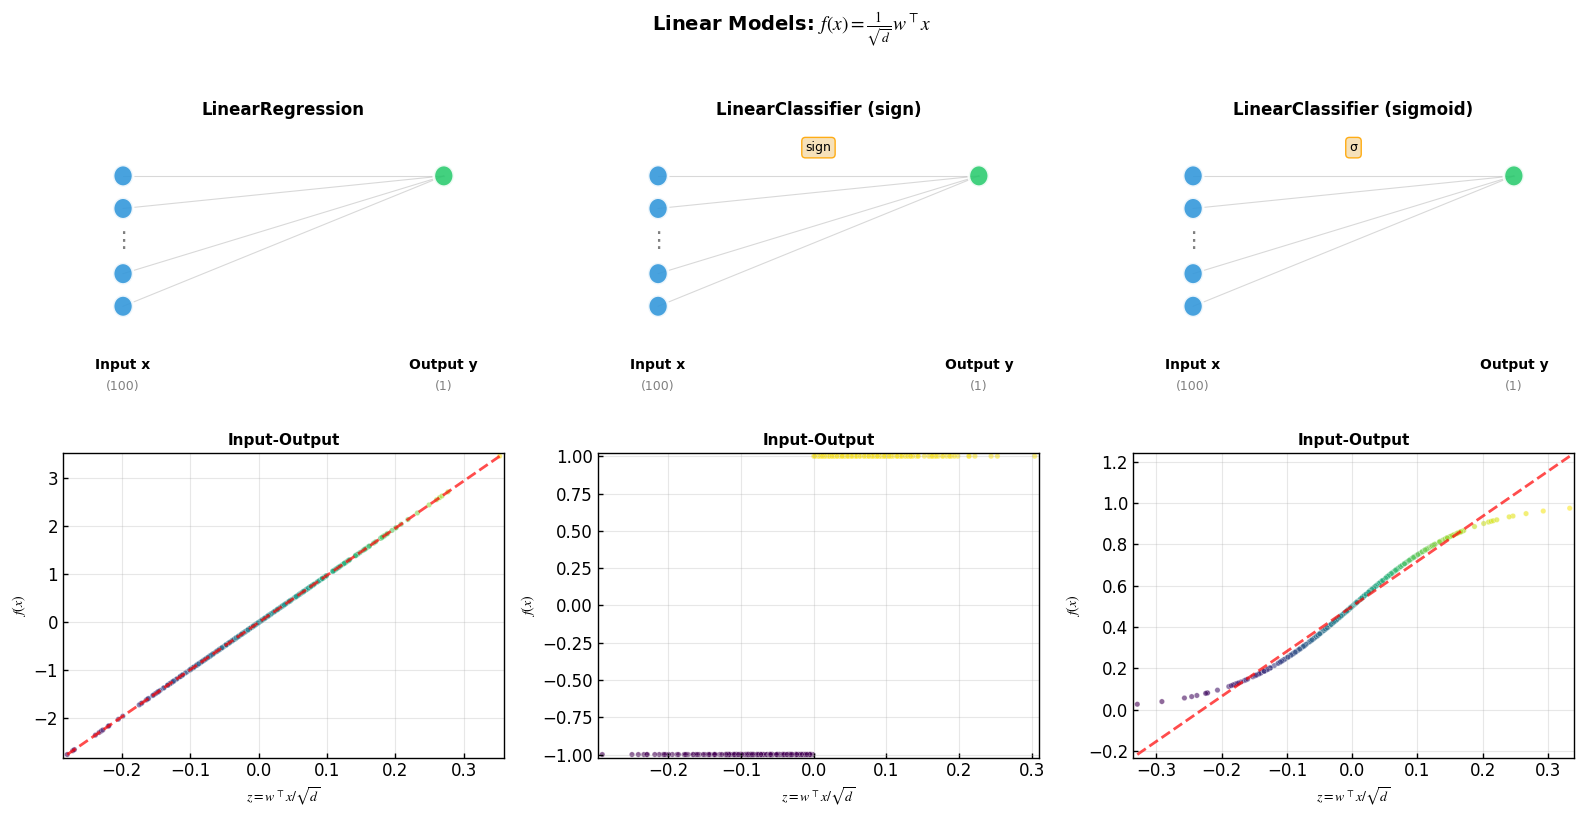

In [3]:
from statphys.model import LinearRegression, LinearClassifier

d = 100

fig = plt.figure(figsize=(16, 8))

# LinearRegression
ax1 = fig.add_subplot(2, 3, 1)
arch = {'layers': [
    {'n': d, 'label': 'Input x', 'type': 'input'},
    {'n': 1, 'label': 'Output y', 'type': 'output'}
]}
draw_network(ax1, arch, title='LinearRegression')

ax2 = fig.add_subplot(2, 3, 4)
model = LinearRegression(d=d)
plot_io(model, d, ax2, 'Input-Output')

# LinearClassifier (sign)
ax3 = fig.add_subplot(2, 3, 2)
arch = {'layers': [
    {'n': d, 'label': 'Input x', 'type': 'input'},
    {'n': 1, 'label': 'Output y', 'type': 'output', 'activation': 'sign'}
]}
draw_network(ax3, arch, title='LinearClassifier (sign)')

ax4 = fig.add_subplot(2, 3, 5)
model = LinearClassifier(d=d, output_type='sign')
plot_io(model, d, ax4, 'Input-Output')

# LinearClassifier (prob)
ax5 = fig.add_subplot(2, 3, 3)
arch = {'layers': [
    {'n': d, 'label': 'Input x', 'type': 'input'},
    {'n': 1, 'label': 'Output y', 'type': 'output', 'activation': 'σ'}
]}
draw_network(ax5, arch, title='LinearClassifier (sigmoid)')

ax6 = fig.add_subplot(2, 3, 6)
model = LinearClassifier(d=d, output_type='prob')
plot_io(model, d, ax6, 'Input-Output')

fig.suptitle(r'Linear Models: $f(x) = \frac{1}{\sqrt{d}} w^\top x$', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# 2. Committee Machines

## Formula

$$f(x) = \frac{1}{\sqrt{K}} \sum_{k=1}^{K} \phi\left( \frac{w_k^\top x}{\sqrt{d}} \right)$$

- **CommitteeMachine**: $\phi = \text{sign}$ (hard decision)
- **SoftCommitteeMachine**: $\phi \in \{\text{erf}, \tanh, \text{ReLU}\}$

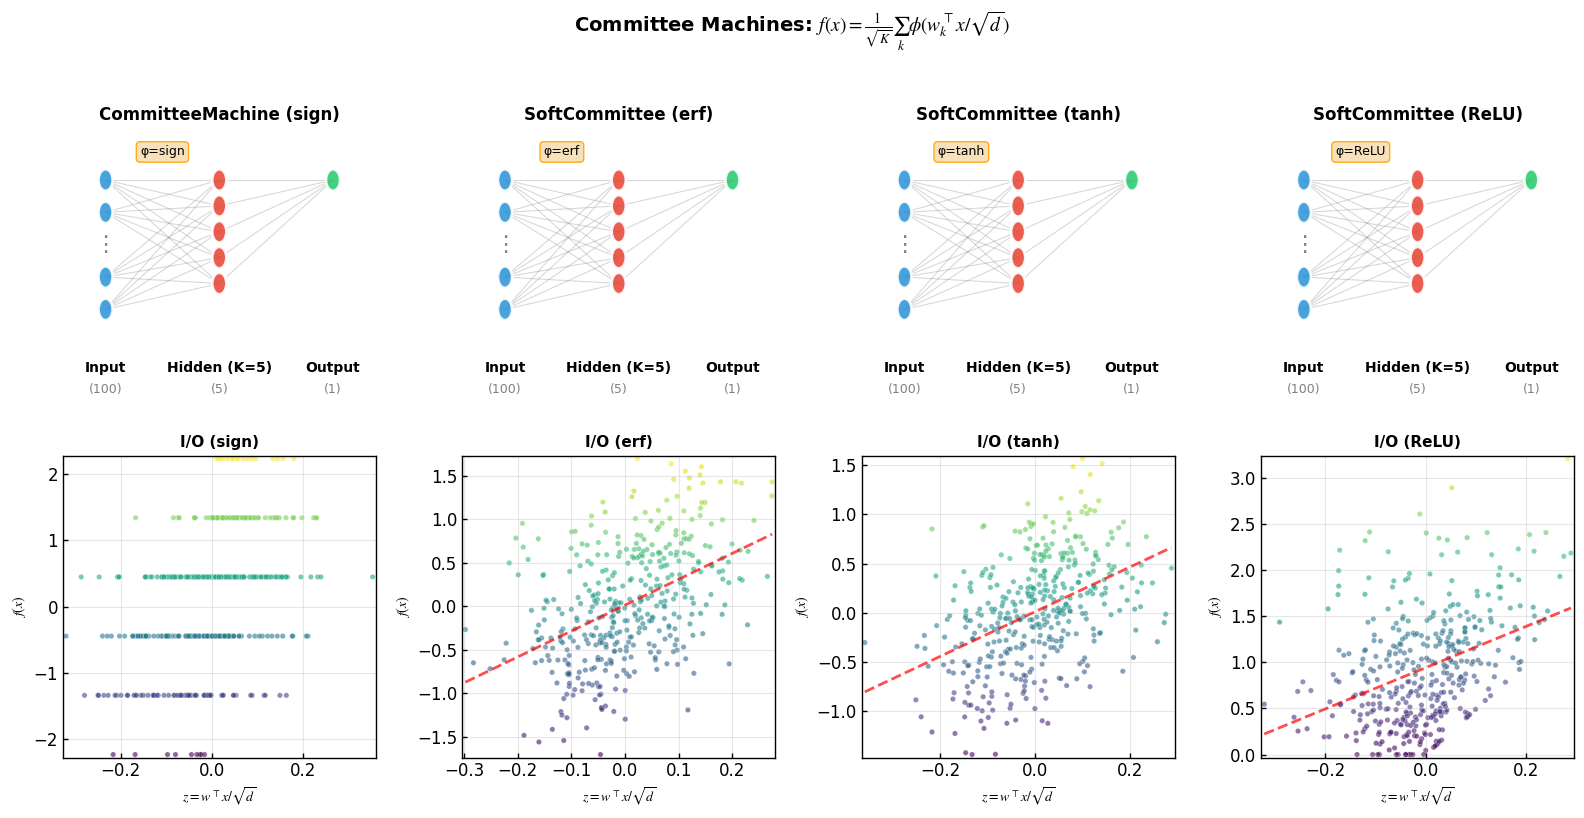

In [4]:
from statphys.model import CommitteeMachine, SoftCommitteeMachine

d, K = 100, 5

fig = plt.figure(figsize=(16, 8))

configs = [
    (CommitteeMachine(d=d, k=K), 'CommitteeMachine', 'sign'),
    (SoftCommitteeMachine(d=d, k=K, activation='erf'), 'SoftCommittee', 'erf'),
    (SoftCommitteeMachine(d=d, k=K, activation='tanh'), 'SoftCommittee', 'tanh'),
    (SoftCommitteeMachine(d=d, k=K, activation='relu'), 'SoftCommittee', 'ReLU'),
]

for idx, (model, name, activation) in enumerate(configs):
    # Network diagram
    ax1 = fig.add_subplot(2, 4, idx + 1)
    arch = {'layers': [
        {'n': d, 'label': 'Input', 'type': 'input'},
        {'n': K, 'label': f'Hidden (K={K})', 'type': 'hidden', 'activation': f'φ={activation}'},
        {'n': 1, 'label': 'Output', 'type': 'output'}
    ]}
    draw_network(ax1, arch, title=f'{name} ({activation})')
    
    # I/O
    ax2 = fig.add_subplot(2, 4, idx + 5)
    plot_io(model, d, ax2, f'I/O ({activation})')

fig.suptitle(r'Committee Machines: $f(x) = \frac{1}{\sqrt{K}} \sum_k \phi(w_k^\top x / \sqrt{d})$', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Activation Functions

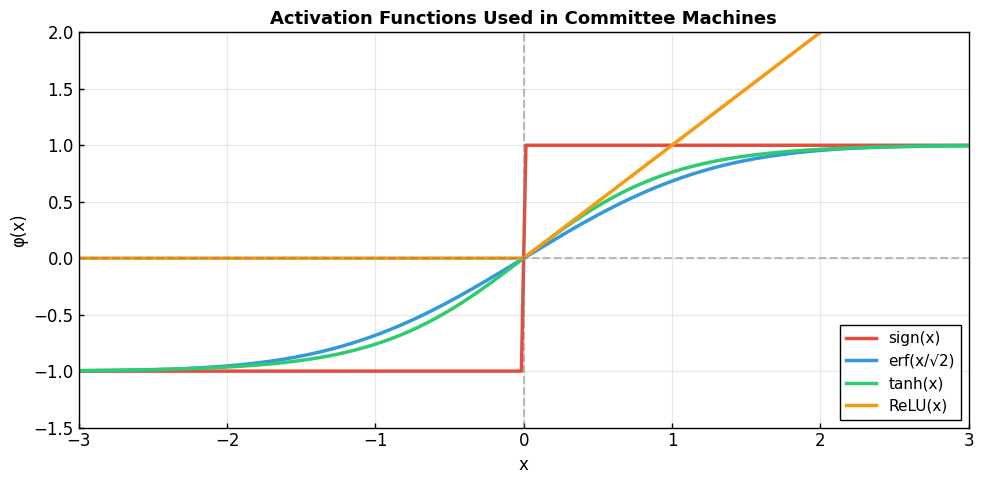

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.linspace(-3, 3, 200)

activations = [
    (np.sign(x), 'sign(x)', '#e74c3c', '-'),
    (scipy_erf(x / np.sqrt(2)), 'erf(x/√2)', '#3498db', '-'),
    (np.tanh(x), 'tanh(x)', '#2ecc71', '-'),
    (np.maximum(0, x), 'ReLU(x)', '#f39c12', '-'),
]

for y, label, color, style in activations:
    ax.plot(x, y, color=color, linestyle=style, linewidth=2.5, label=label)

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('φ(x)', fontsize=12)
ax.set_title('Activation Functions Used in Committee Machines', fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_xlim(-3, 3)
ax.set_ylim(-1.5, 2)

plt.tight_layout()
plt.show()

---

# 3. Two-Layer Networks (MLP)

## Formula

$$f(x) = \frac{1}{\sqrt{K}} a^\top \phi\left( \frac{W x}{\sqrt{d}} \right)$$

where $W \in \mathbb{R}^{K \times d}$ (first layer) and $a \in \mathbb{R}^K$ (second layer, learnable or fixed)

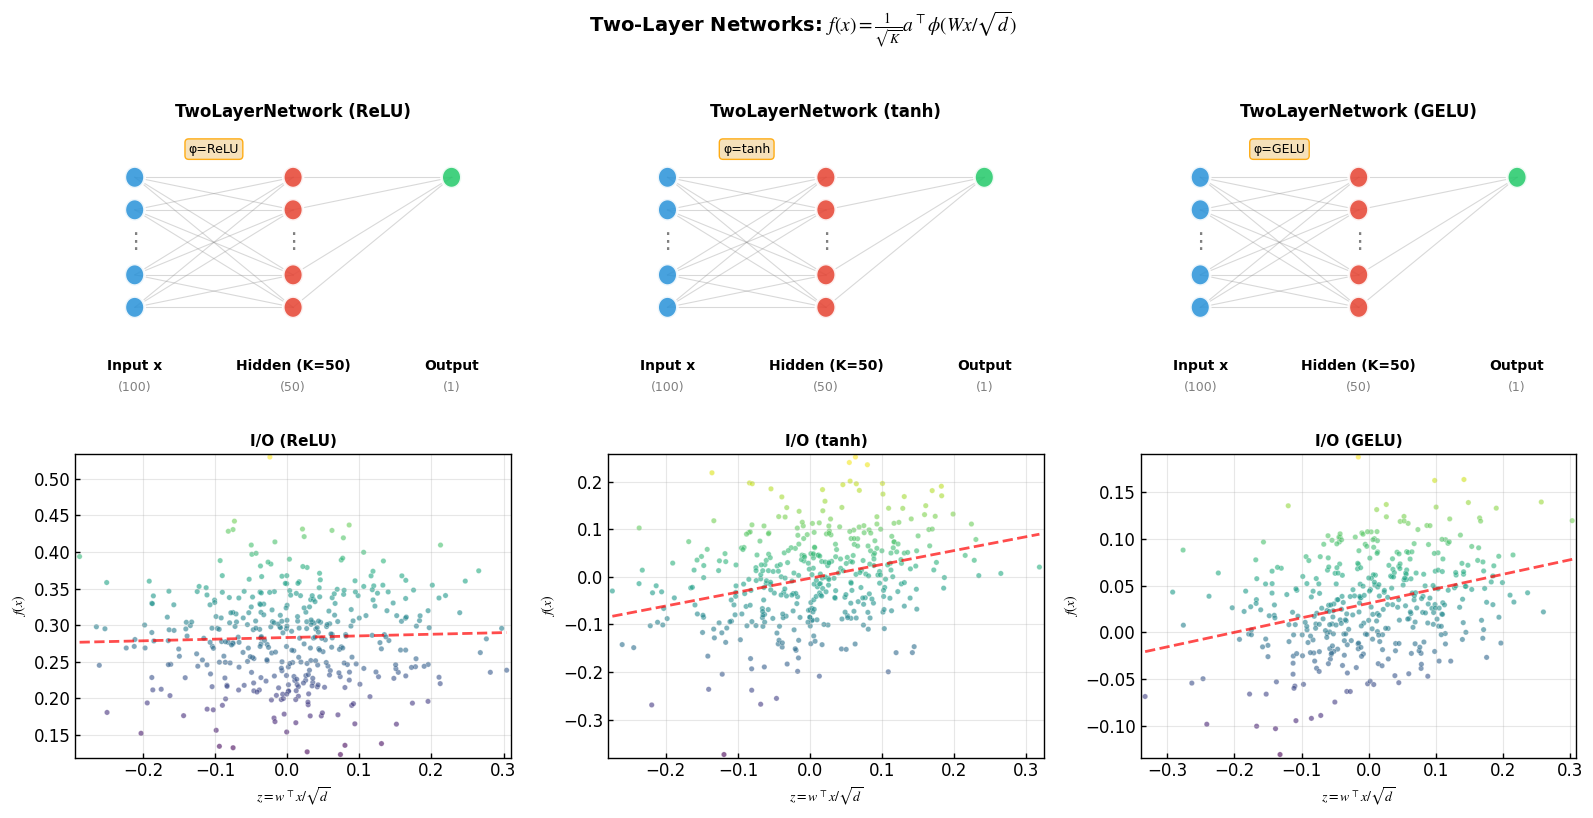

In [6]:
from statphys.model import TwoLayerNetwork, TwoLayerNetworkReLU

d, K = 100, 50

fig = plt.figure(figsize=(16, 8))

configs = [
    (TwoLayerNetwork(d=d, k=K, activation='relu'), 'TwoLayerNetwork', 'ReLU'),
    (TwoLayerNetwork(d=d, k=K, activation='tanh'), 'TwoLayerNetwork', 'tanh'),
    (TwoLayerNetwork(d=d, k=K, activation='gelu'), 'TwoLayerNetwork', 'GELU'),
]

for idx, (model, name, activation) in enumerate(configs):
    ax1 = fig.add_subplot(2, 3, idx + 1)
    arch = {'layers': [
        {'n': d, 'label': 'Input x', 'type': 'input'},
        {'n': K, 'label': f'Hidden (K={K})', 'type': 'hidden', 'activation': f'φ={activation}'},
        {'n': 1, 'label': 'Output', 'type': 'output'}
    ]}
    draw_network(ax1, arch, title=f'{name} ({activation})')
    
    ax2 = fig.add_subplot(2, 3, idx + 4)
    plot_io(model, d, ax2, f'I/O ({activation})')

fig.suptitle(r'Two-Layer Networks: $f(x) = \frac{1}{\sqrt{K}} a^\top \phi(Wx / \sqrt{d})$', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# 4. Deep Linear Network

## Formula

$$f(x) = \frac{1}{d^{L/2}} W^{(L)} W^{(L-1)} \cdots W^{(1)} x$$

Identity activation (linear): enables exact statistical mechanics analysis of deep networks

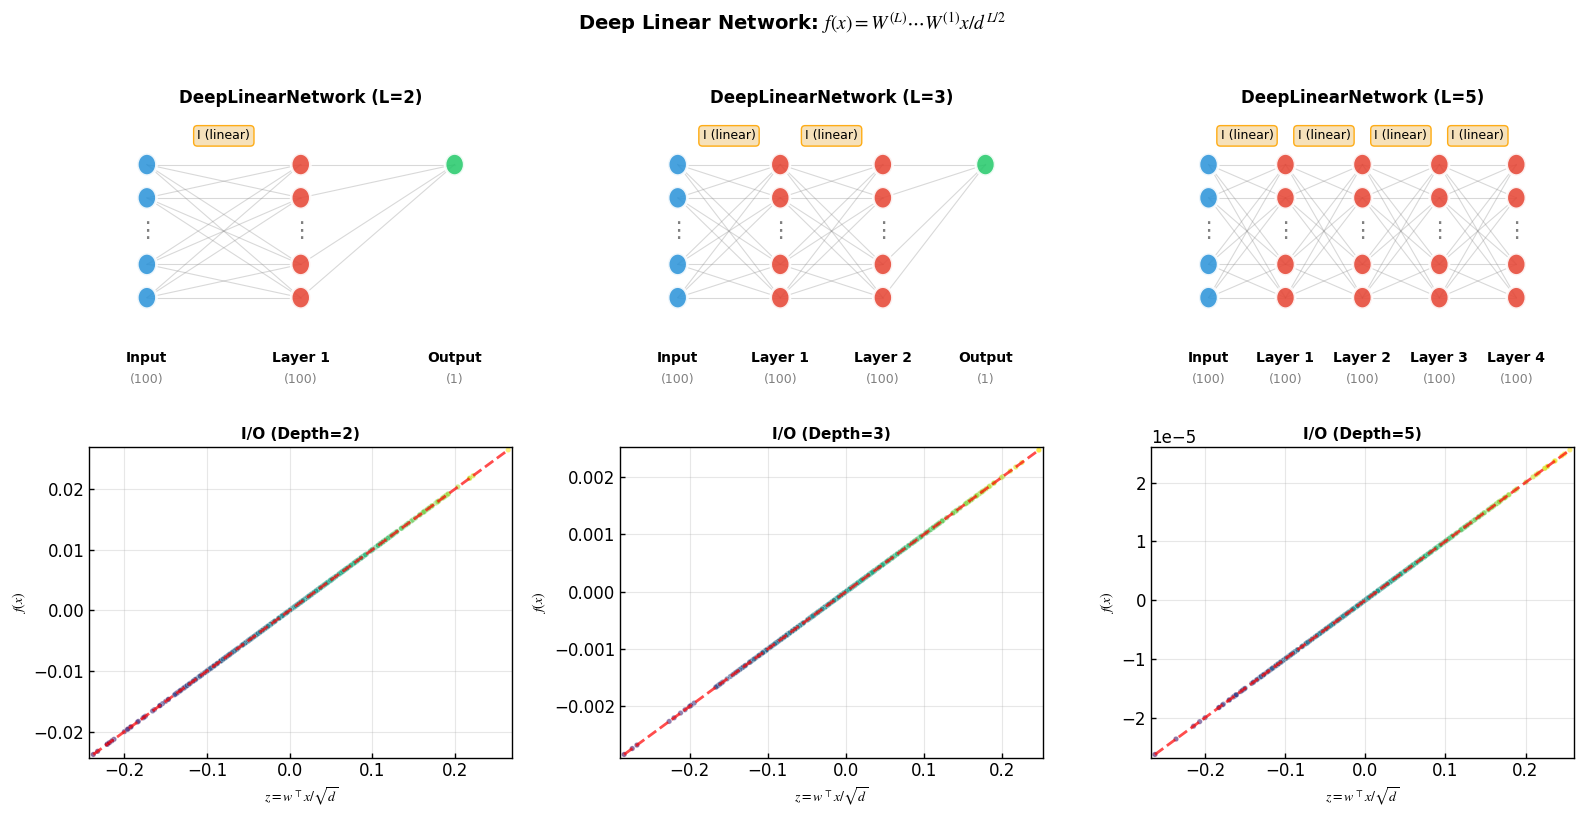

In [7]:
from statphys.model import DeepLinearNetwork

d = 100

fig = plt.figure(figsize=(16, 8))

depths = [2, 3, 5]
for idx, depth in enumerate(depths):
    model = DeepLinearNetwork(d=d, depth=depth, width=d)
    
    ax1 = fig.add_subplot(2, 3, idx + 1)
    layers = [{'n': d, 'label': 'Input', 'type': 'input'}]
    for l in range(depth - 1):
        layers.append({'n': d, 'label': f'Layer {l+1}', 'type': 'hidden', 'activation': 'I (linear)'})
    layers.append({'n': 1, 'label': 'Output', 'type': 'output'})
    
    arch = {'layers': layers[:5]}  # Show max 5 layers
    draw_network(ax1, arch, title=f'DeepLinearNetwork (L={depth})')
    
    ax2 = fig.add_subplot(2, 3, idx + 4)
    plot_io(model, d, ax2, f'I/O (Depth={depth})')

fig.suptitle(r'Deep Linear Network: $f(x) = W^{(L)} \cdots W^{(1)} x / d^{L/2}$', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# 5. Random Features / Kernel Models

## Formula

$$f(x) = \frac{1}{\sqrt{P}} a^\top \phi\left( \frac{B x}{\sqrt{d}} \right)$$

where $B \in \mathbb{R}^{P \times d}$ is **fixed random** and $a \in \mathbb{R}^P$ is learnable.

Equivalent to kernel ridge regression as $P \to \infty$.

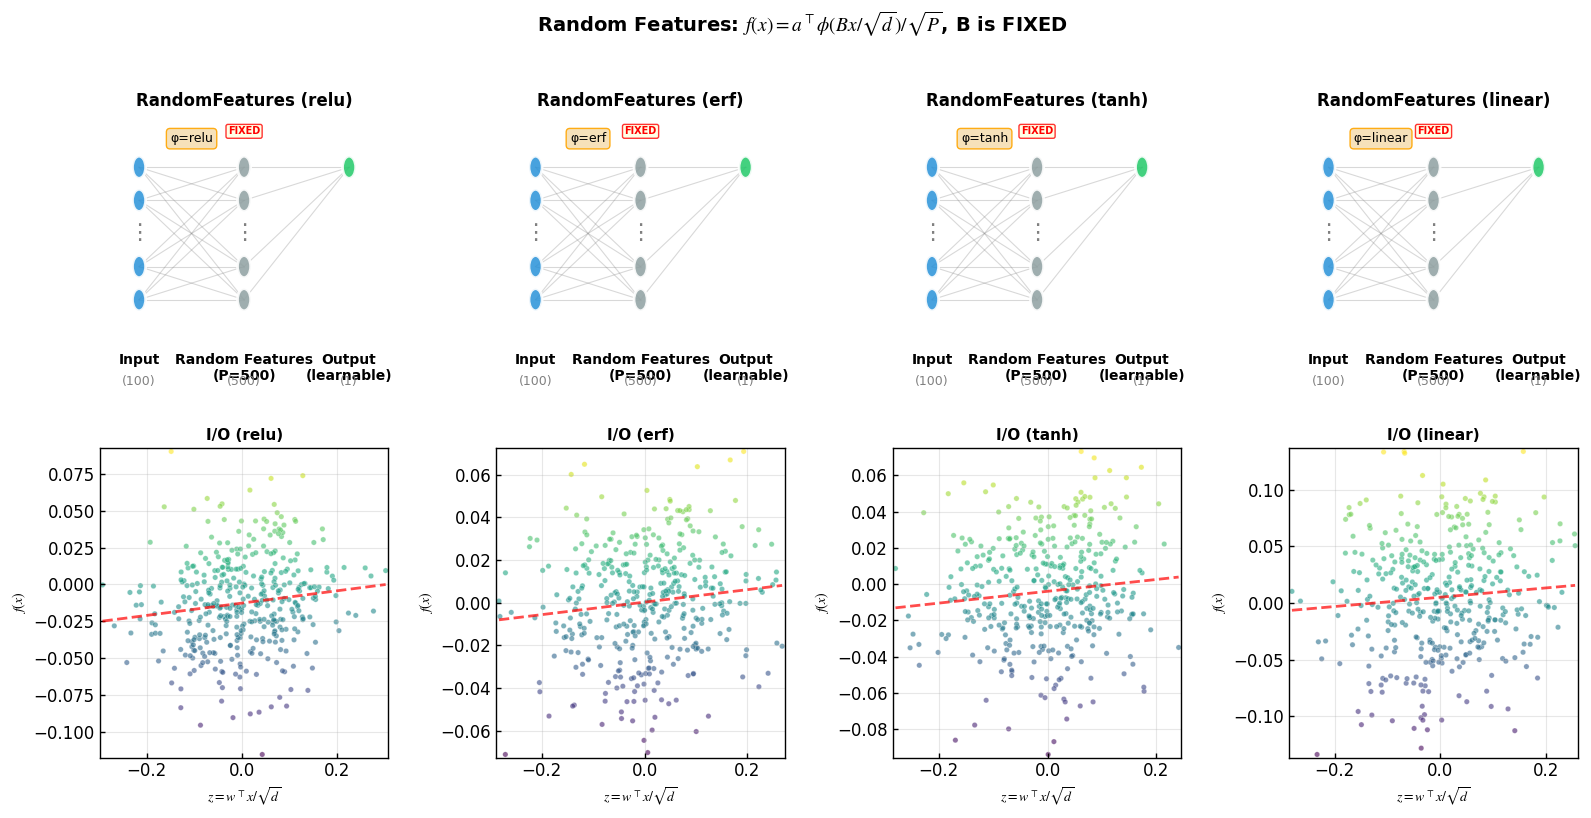

In [8]:
from statphys.model import RandomFeaturesModel

d, P = 100, 500

fig = plt.figure(figsize=(16, 8))

activations = ['relu', 'erf', 'tanh', 'linear']
for idx, activation in enumerate(activations):
    model = RandomFeaturesModel(d=d, p=P, activation=activation)
    
    ax1 = fig.add_subplot(2, 4, idx + 1)
    arch = {'layers': [
        {'n': d, 'label': 'Input', 'type': 'input'},
        {'n': P, 'label': f'Random Features\n(P={P})', 'type': 'hidden', 
         'activation': f'φ={activation}', 'fixed': True},
        {'n': 1, 'label': 'Output\n(learnable)', 'type': 'output'}
    ]}
    draw_network(ax1, arch, title=f'RandomFeatures ({activation})')
    
    ax2 = fig.add_subplot(2, 4, idx + 5)
    plot_io(model, d, ax2, f'I/O ({activation})')

fig.suptitle(r'Random Features: $f(x) = a^\top \phi(Bx / \sqrt{d}) / \sqrt{P}$, B is FIXED', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# 6. Softmax Regression (Multi-class)

## Formula

$$P(y = k | x) = \frac{\exp\left( w_k^\top x / \sqrt{d} \right)}{\sum_{j=1}^{K} \exp\left( w_j^\top x / \sqrt{d} \right)} = \text{softmax}\left( \frac{Wx}{\sqrt{d}} \right)_k$$

where $W \in \mathbb{R}^{K \times d}$, one weight vector per class

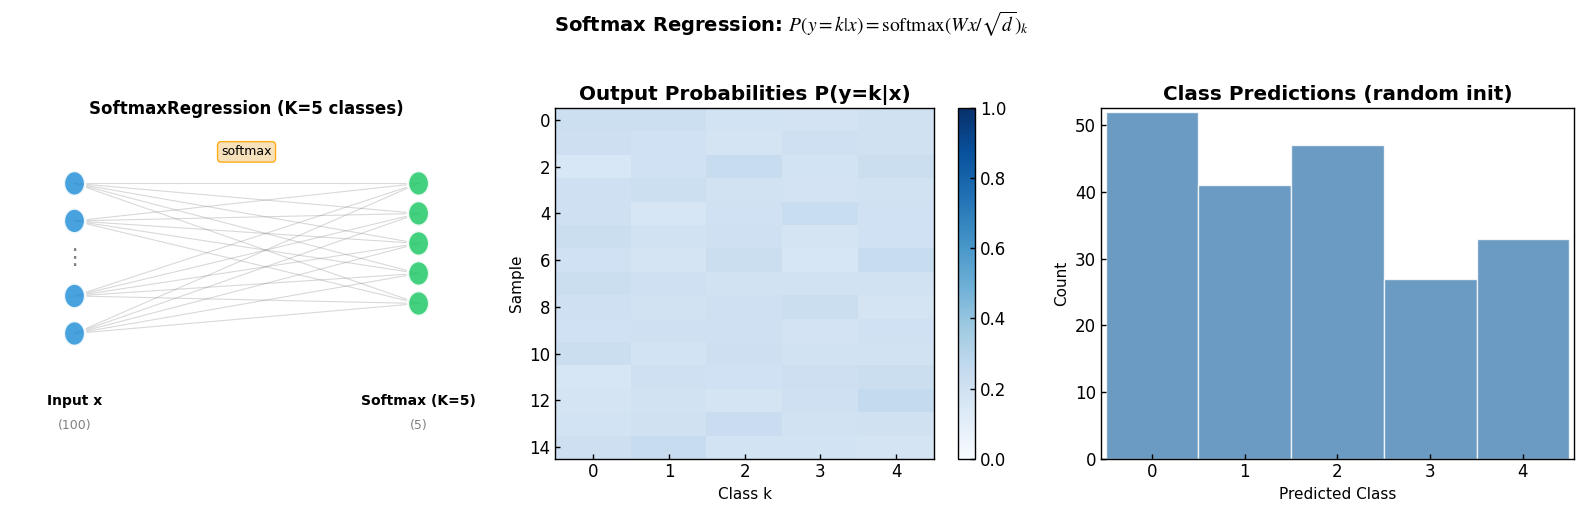

In [9]:
from statphys.model import SoftmaxRegression

d, n_classes = 100, 5

fig = plt.figure(figsize=(16, 5))

# Network diagram
ax1 = fig.add_subplot(1, 3, 1)
arch = {'layers': [
    {'n': d, 'label': 'Input x', 'type': 'input'},
    {'n': n_classes, 'label': f'Softmax (K={n_classes})', 'type': 'output', 'activation': 'softmax'}
]}
draw_network(ax1, arch, title=f'SoftmaxRegression (K={n_classes} classes)')

# Output probabilities
ax2 = fig.add_subplot(1, 3, 2)
model = SoftmaxRegression(d=d, n_classes=n_classes)
X = torch.randn(15, d)
with torch.no_grad():
    probs = model(X).numpy()

im = ax2.imshow(probs, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax2.set_xlabel('Class k', fontsize=11)
ax2.set_ylabel('Sample', fontsize=11)
ax2.set_title('Output Probabilities P(y=k|x)', fontweight='bold')
ax2.set_xticks(range(n_classes))
plt.colorbar(im, ax=ax2)

# Class predictions
ax3 = fig.add_subplot(1, 3, 3)
X_test = torch.randn(200, d)
with torch.no_grad():
    preds = model.predict(X_test).numpy()
ax3.hist(preds, bins=np.arange(n_classes+1)-0.5, edgecolor='white', 
        color='steelblue', alpha=0.8)
ax3.set_xlabel('Predicted Class', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Class Predictions (random init)', fontweight='bold')
ax3.set_xticks(range(n_classes))

fig.suptitle(r'Softmax Regression: $P(y=k|x) = \text{softmax}(Wx/\sqrt{d})_k$', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

# 7. Transformer Models

## SingleLayerAttention Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^\top}{\sqrt{d_k}} \right) V$$

where $Q = X W_Q$, $K = X W_K$, $V = X W_V$

## SingleLayerTransformer Formula

$$\text{Transformer}(X) = \text{FFN}\left( X + \text{Attention}(X) \right)$$

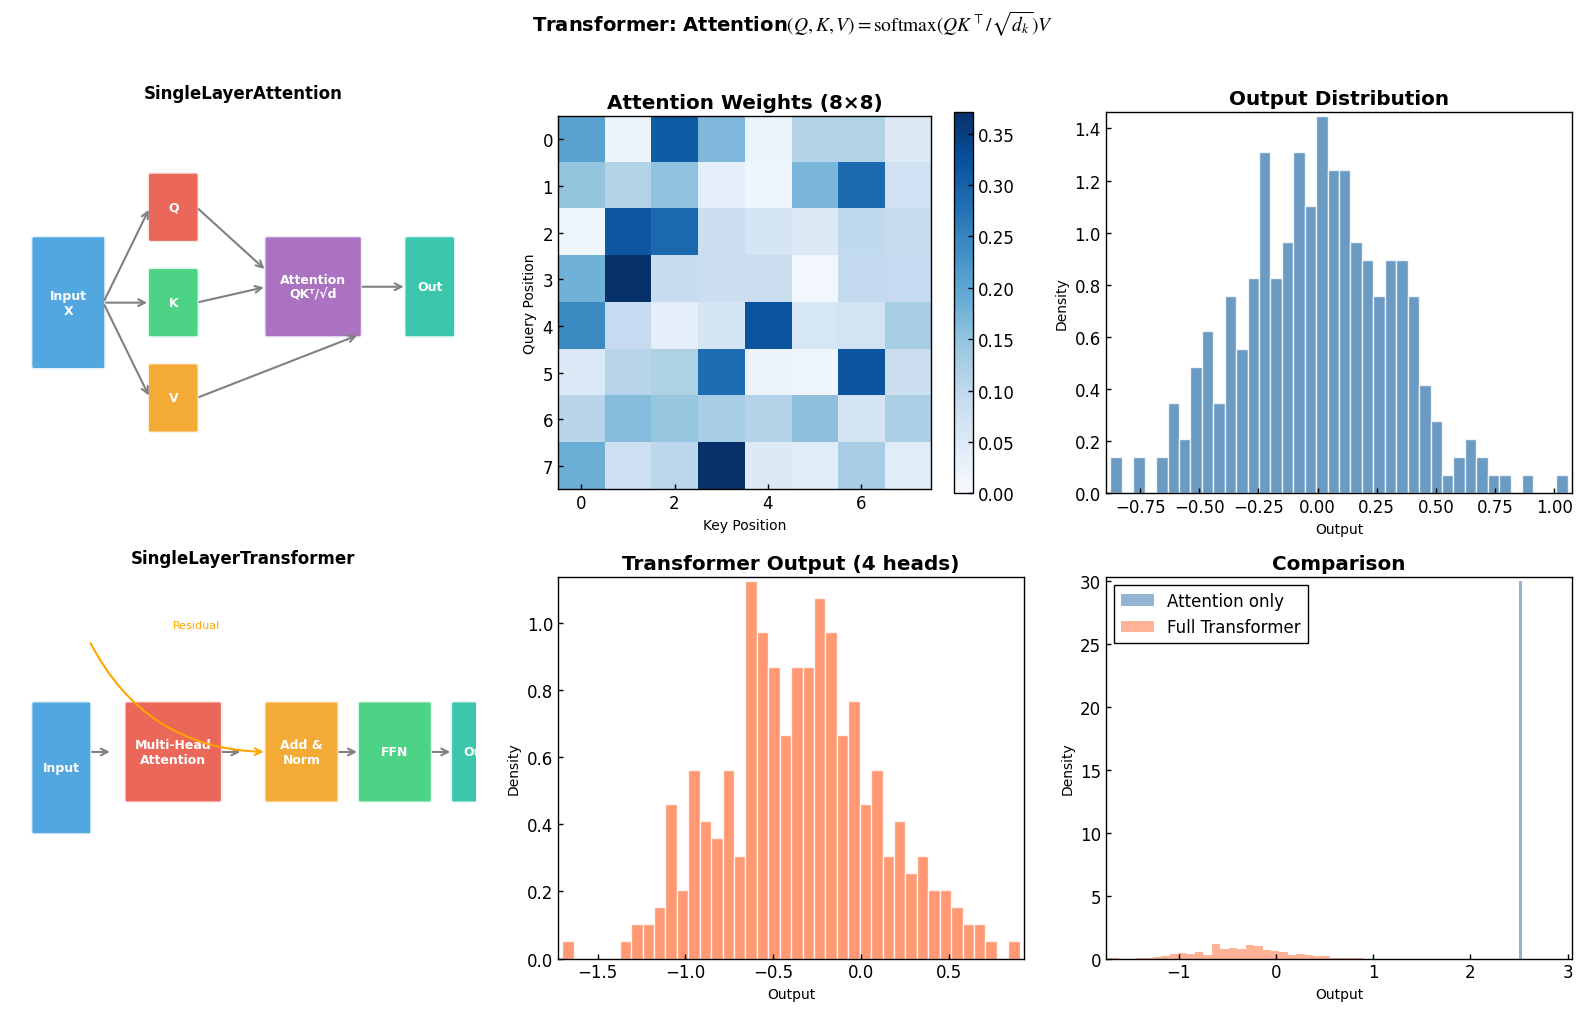

In [10]:
from statphys.model import SingleLayerAttention, SingleLayerTransformer

d, d_model, n_heads = 64, 32, 4

fig = plt.figure(figsize=(16, 10))

# ========== SingleLayerAttention ==========
ax1 = fig.add_subplot(2, 3, 1)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6)
ax1.axis('off')

# Draw attention architecture
boxes = [
    (0.5, 2, 1.5, 2, 'Input\nX', '#3498db'),
    (3, 4, 1, 1, 'Q', '#e74c3c'),
    (3, 2.5, 1, 1, 'K', '#2ecc71'),
    (3, 1, 1, 1, 'V', '#f39c12'),
    (5.5, 2.5, 2, 1.5, 'Attention\nQKᵀ/√d', '#9b59b6'),
    (8.5, 2.5, 1, 1.5, 'Out', '#1abc9c'),
]

for x, y, w, h, label, color in boxes:
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.05",
                          facecolor=color, alpha=0.85, edgecolor='white', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=9, 
            color='white', fontweight='bold')

# Arrows
arrows = [(2, 3, 3, 4.5), (2, 3, 3, 3), (2, 3, 3, 1.5),
          (4, 4.5, 5.5, 3.5), (4, 3, 5.5, 3.25), (4, 1.5, 7.5, 2.5),
          (7.5, 3.25, 8.5, 3.25)]
for x1, y1, x2, y2 in arrows:
    ax1.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax1.set_title('SingleLayerAttention', fontsize=12, fontweight='bold', pad=10)

# Attention weights
ax2 = fig.add_subplot(2, 3, 2)
model_attn = SingleLayerAttention(d=d, d_model=d_model, n_heads=1)
X = torch.randn(1, 8, d)
with torch.no_grad():
    Q = X @ model_attn.W_q.T
    K = X @ model_attn.W_k.T
    attn = torch.softmax(Q @ K.transpose(-2, -1) / np.sqrt(d_model), dim=-1)
    attn_np = attn[0].numpy()

im = ax2.imshow(attn_np, cmap='Blues', vmin=0)
ax2.set_xlabel('Key Position', fontsize=10)
ax2.set_ylabel('Query Position', fontsize=10)
ax2.set_title('Attention Weights (8×8)', fontweight='bold')
plt.colorbar(im, ax=ax2)

# Output distribution
ax3 = fig.add_subplot(2, 3, 3)
X_batch = torch.randn(300, 8, d)
with torch.no_grad():
    y = model_attn(X_batch).numpy()
ax3.hist(y, bins=40, density=True, alpha=0.8, color='steelblue', edgecolor='white')
ax3.set_xlabel('Output', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Output Distribution', fontweight='bold')

# ========== SingleLayerTransformer ==========
ax4 = fig.add_subplot(2, 3, 4)
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 6)
ax4.axis('off')

# Draw transformer architecture
boxes = [
    (0.5, 2, 1.2, 2, 'Input', '#3498db'),
    (2.5, 2.5, 2, 1.5, 'Multi-Head\nAttention', '#e74c3c'),
    (5.5, 2.5, 1.5, 1.5, 'Add &\nNorm', '#f39c12'),
    (7.5, 2.5, 1.5, 1.5, 'FFN', '#2ecc71'),
    (9.5, 2.5, 1, 1.5, 'Out', '#1abc9c'),
]

for x, y, w, h, label, color in boxes:
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.05",
                          facecolor=color, alpha=0.85, edgecolor='white', linewidth=2)
    ax4.add_patch(rect)
    ax4.text(x + w/2, y + h/2, label, ha='center', va='center', fontsize=9, 
            color='white', fontweight='bold')

# Arrows
for x in [1.7, 4.5, 7, 9]:
    ax4.annotate('', xy=(x+0.5, 3.25), xytext=(x, 3.25),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Residual connection
ax4.annotate('', xy=(5.5, 3.25), xytext=(1.7, 5),
            arrowprops=dict(arrowstyle='->', color='orange', lw=1.5, 
                           connectionstyle='arc3,rad=0.3'))
ax4.text(3.5, 5.2, 'Residual', fontsize=8, color='orange')

ax4.set_title('SingleLayerTransformer', fontsize=12, fontweight='bold', pad=10)

# Transformer output
ax5 = fig.add_subplot(2, 3, 5)
model_trans = SingleLayerTransformer(d=d, d_model=d_model, n_heads=n_heads)
with torch.no_grad():
    y_trans = model_trans(X_batch).numpy()
ax5.hist(y_trans, bins=40, density=True, alpha=0.8, color='coral', edgecolor='white')
ax5.set_xlabel('Output', fontsize=10)
ax5.set_ylabel('Density', fontsize=10)
ax5.set_title(f'Transformer Output ({n_heads} heads)', fontweight='bold')

# Comparison
ax6 = fig.add_subplot(2, 3, 6)
ax6.hist(y, bins=30, density=True, alpha=0.6, label='Attention only', color='steelblue')
ax6.hist(y_trans, bins=30, density=True, alpha=0.6, label='Full Transformer', color='coral')
ax6.set_xlabel('Output', fontsize=10)
ax6.set_ylabel('Density', fontsize=10)
ax6.set_title('Comparison', fontweight='bold')
ax6.legend()

fig.suptitle(r'Transformer: Attention$(Q,K,V) = \text{softmax}(QK^\top/\sqrt{d_k}) V$', 
            fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---

# 8. Complete Model Gallery

Summary of all 15 models with input-output relationships.

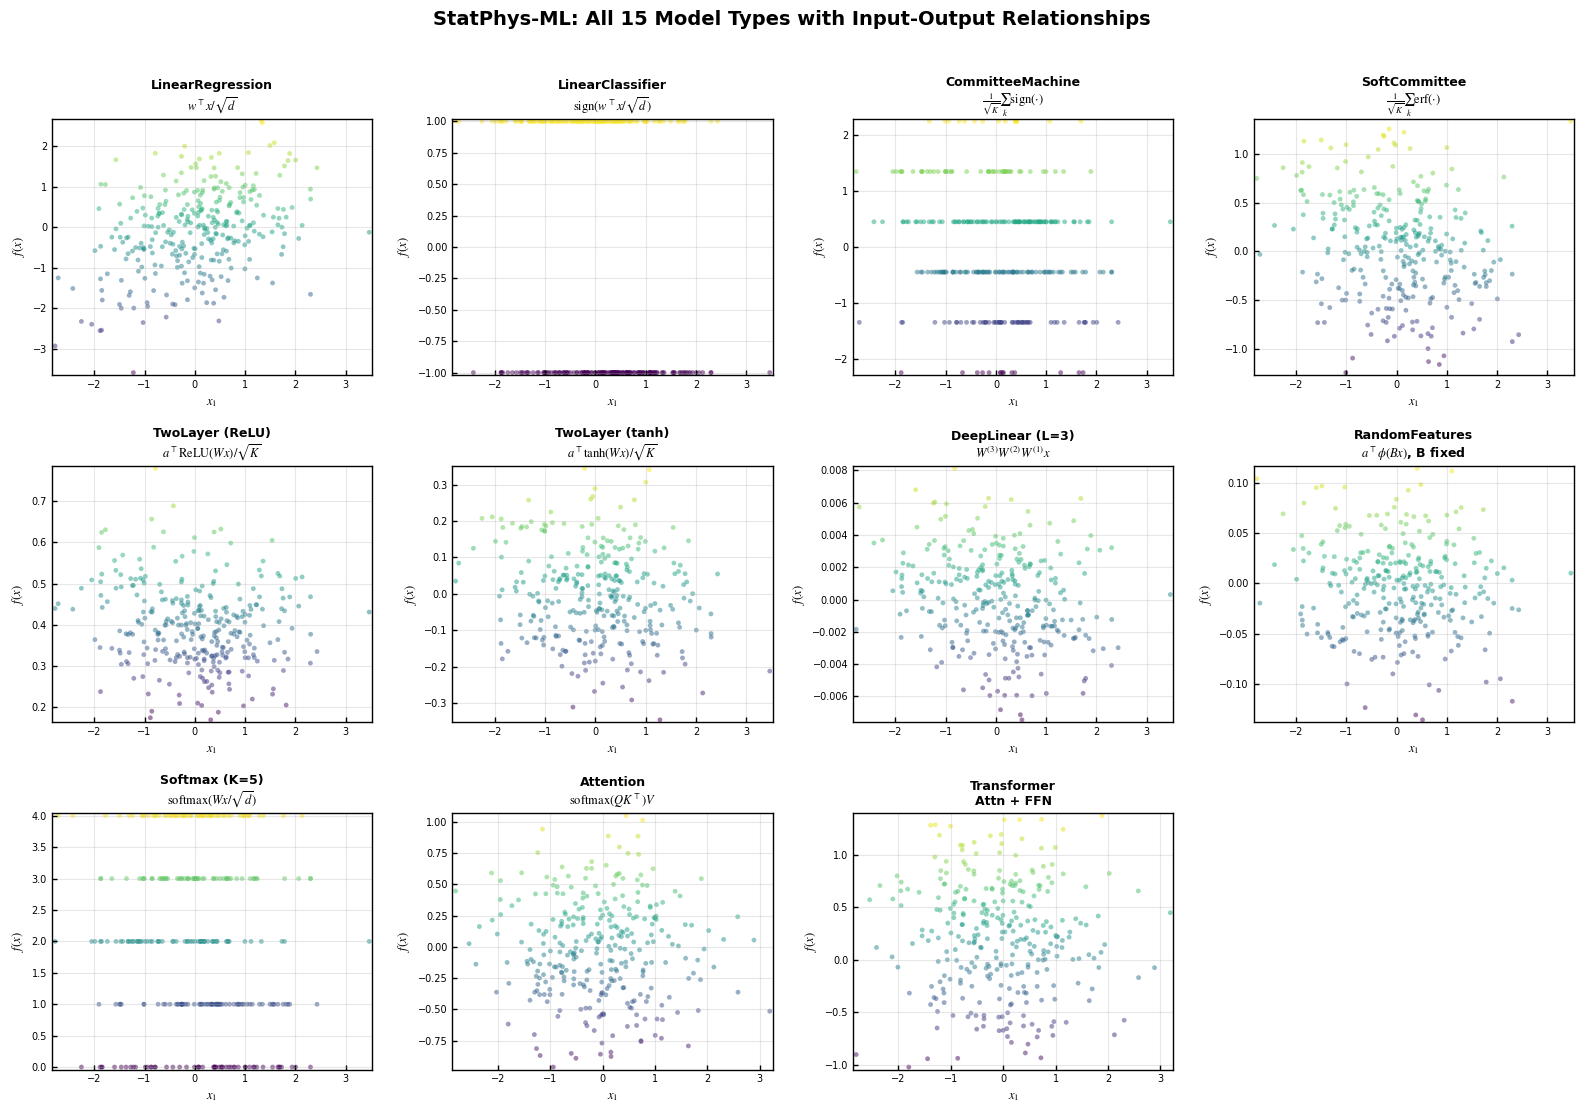


Saved: model_gallery_summary.png


In [11]:
from statphys.model import (
    LinearRegression, LinearClassifier,
    CommitteeMachine, SoftCommitteeMachine,
    TwoLayerNetwork, DeepNetwork, DeepLinearNetwork,
    RandomFeaturesModel, SoftmaxRegression,
    SingleLayerAttention, SingleLayerTransformer,
)

d = 50
fig, axes = plt.subplots(3, 4, figsize=(16, 11))

models_info = [
    (LinearRegression(d=d), 'LinearRegression', r'$w^\top x / \sqrt{d}$'),
    (LinearClassifier(d=d, output_type='sign'), 'LinearClassifier', r'$\text{sign}(w^\top x / \sqrt{d})$'),
    (CommitteeMachine(d=d, k=5), 'CommitteeMachine', r'$\frac{1}{\sqrt{K}}\sum_k \text{sign}(\cdot)$'),
    (SoftCommitteeMachine(d=d, k=5, activation='erf'), 'SoftCommittee', r'$\frac{1}{\sqrt{K}}\sum_k \text{erf}(\cdot)$'),
    (TwoLayerNetwork(d=d, k=50, activation='relu'), 'TwoLayer (ReLU)', r'$a^\top \text{ReLU}(Wx) / \sqrt{K}$'),
    (TwoLayerNetwork(d=d, k=50, activation='tanh'), 'TwoLayer (tanh)', r'$a^\top \tanh(Wx) / \sqrt{K}$'),
    (DeepLinearNetwork(d=d, depth=3), 'DeepLinear (L=3)', r'$W^{(3)}W^{(2)}W^{(1)}x$'),
    (RandomFeaturesModel(d=d, p=200), 'RandomFeatures', r'$a^\top \phi(Bx)$, B fixed'),
    (SoftmaxRegression(d=d, n_classes=5), 'Softmax (K=5)', r'$\text{softmax}(Wx/\sqrt{d})$'),
    (SingleLayerAttention(d=d, d_model=32), 'Attention', r'$\text{softmax}(QK^\top)V$'),
    (SingleLayerTransformer(d=d, d_model=32), 'Transformer', 'Attn + FFN'),
]

X = torch.randn(300, d)
X_seq = torch.randn(300, 5, d)

for idx, (model, name, formula) in enumerate(models_info):
    row, col = idx // 4, idx % 4
    ax = axes[row, col]
    
    with torch.no_grad():
        if 'Attention' in name or 'Transformer' in name:
            y = model(X_seq).numpy()
            x_plot = X_seq[:, 0, 0].numpy()
        else:
            y = model(X)
            if y.dim() > 1 and y.shape[1] > 1:
                y = y.argmax(dim=1).float()
            y = y.numpy().flatten()
            x_plot = X[:, 0].numpy()
    
    scatter = ax.scatter(x_plot, y, c=y, cmap='viridis', alpha=0.5, s=12, edgecolors='none')
    ax.set_xlabel('$x_1$', fontsize=9)
    ax.set_ylabel('$f(x)$', fontsize=9)
    ax.set_title(f'{name}\n{formula}', fontsize=9, fontweight='bold')
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[2, 3].axis('off')

fig.suptitle('StatPhys-ML: All 15 Model Types with Input-Output Relationships', 
            fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('model_gallery_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved: model_gallery_summary.png")

---

# Summary Table

| Category | Model | Formula |
|----------|-------|--------|
| **Linear** | `LinearRegression` | $f(x) = w^\top x / \sqrt{d}$ |
| | `LinearClassifier` | $f(x) = \phi(w^\top x / \sqrt{d})$, $\phi \in \{\text{sign}, \sigma\}$ |
| | `RidgeRegression` | Same + L2 regularization |
| **Committee** | `CommitteeMachine` | $f(x) = \frac{1}{\sqrt{K}} \sum_k \text{sign}(w_k^\top x / \sqrt{d})$ |
| | `SoftCommitteeMachine` | $f(x) = \frac{1}{\sqrt{K}} \sum_k \phi(w_k^\top x / \sqrt{d})$ |
| **MLP** | `TwoLayerNetwork` | $f(x) = \frac{1}{\sqrt{K}} a^\top \phi(Wx / \sqrt{d})$ |
| | `DeepNetwork` | Multi-layer composition |
| **Deep Linear** | `DeepLinearNetwork` | $f(x) = W^{(L)} \cdots W^{(1)} x / d^{L/2}$ |
| **Random Features** | `RandomFeaturesModel` | $f(x) = \frac{1}{\sqrt{P}} a^\top \phi(Bx / \sqrt{d})$, B fixed |
| | `KernelRidgeModel` | Same (kernel approximation) |
| **Softmax** | `SoftmaxRegression` | $P(y=k|x) = \text{softmax}(Wx / \sqrt{d})_k$ |
| **Transformer** | `SingleLayerAttention` | $\text{Attention}(Q,K,V) = \text{softmax}(QK^\top/\sqrt{d_k})V$ |
| | `SingleLayerTransformer` | Attention + FFN with residuals |